In [1]:
import os
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import time
from utils import generate_gauss_dataset, exact_beta, kernel_mat, weight_kulsif_analytic
from utils import loss_regularized, loss_regularized3, ker, estimated_beta_analytic, evaluate, evaluate2
from utils import Jacobian_expweight
from scipy.stats import norm
from scipy import optimize
from numdifftools import Jacobian, Hessian

# plottting
%config InlineBackend.figure_formats = ['svg']
plt.rcParams.update({'font.size': 8})

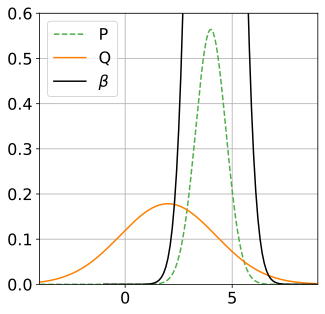

In [2]:
# generate Gaussian data
seed = 0
m = n = 10
#Source data 
mu_S = 2
sigma_S= np.sqrt(5)  # mean and standard deviation
#target data
mu_T = 4
sigma_T = np.sqrt(0.5)  # mean and standard deviation
source_X, target_X = generate_gauss_dataset(seed,n,m,mu_S,sigma_S,mu_T,sigma_T)
x_new = np.arange(-1,9,1e-1)
betas_true = exact_beta(mu_S,sigma_S, mu_T, sigma_T,x_new)

# plot data
plt.figure(1,figsize=(5,5))
plt.rcParams['font.size'] = '16'
if sigma_S > sigma_T:
    x = np.linspace(mu_S - 3.5*sigma_S, mu_S + 3.5*sigma_S, 1000)
else:
    x = np.linspace(mu_T - 3.5*sigma_T, mu_T + 3.5*sigma_T, 1000)
plt.plot(x, norm.pdf(x, mu_T, sigma_T),c = '#4daf4a',label="P",linestyle='dashed')
plt.plot(x, norm.pdf(x, loc=mu_S,scale=sigma_S),label='Q',c = '#ff7f00')
plt.plot(x_new, betas_true, 'k-', label=r'$\beta$')
plt.ylim([0,.6])
plt.xlim([-4,9])
plt.grid()
plt.legend()
path = f'results_quasi/mean_T_{mu_T}/'
if not os.path.exists(path):
   os.makedirs(path)
plt.savefig(path + f'data_muT_{mu_T}.png',dpi=300)

In [ ]:
def big_eval(seed, m, num_iterations=10, legend=False):
    # generate data
    n=m
    mu_S = 2
    sigma_S= np.sqrt(5)
    mu_T = 4
    sigma_T = np.sqrt(0.5)
    source_X, target_X = generate_gauss_dataset(seed,n,m,mu_S,sigma_S,mu_T,sigma_T)
    x_new = np.arange(0,8,1e-1)
    # fix regularization parameter sequence
    alphas = 10.**np.arange(-6,2,2)
    print('dataset-size: '+str(source_X.shape[0]+target_X.shape[0]))
    # compute kernel matrix
    Kb = kernel_mat(source_X, target_X)
    K = kernel_mat(source_X, target_X)[m:,m:]# needed for analytic kulsif

    f_beta, axs = plt.subplots(1, len(alphas), figsize=(15,2))
    mses = np.ones(alphas.shape[0])
    betas_true=exact_beta(mu_S,sigma_S, mu_T, sigma_T,x_new)
    betas_est_iter = np.zeros((alphas.shape[0],x_new.shape[0]))
    betas_est_iter_kulsif = np.zeros((alphas.shape[0],x_new.shape[0]))
    weights_exp = np.zeros((alphas.shape[0],m+n))
    weights_kulsif = np.zeros((alphas.shape[0],m+n))
    weights = np.ones((alphas.shape[0],n))
    for i, ax in zip(range(alphas.shape[0]), axs.ravel()):
        print('alpha: '+str(alphas[i])+' perc: '+str((i)/alphas.shape[0]), end='\r')
        loss = lambda alpha: loss_regularized3(source_X, target_X, Kb, alpha, alphas[i], method='ExpWeight')
        jacobian = lambda alpha: Jacobian_expweight(source_X,target_X,Kb,alpha, alphas[i]).ravel()
        def fun_der(alpha):
            return Jacobian(lambda x: loss(alpha.ravel()))(alpha.ravel()).ravel()
        print('shape is '+str(fun_der(np.zeros(m+n).ravel()).shape))
        sol = optimize.minimize(loss, np.zeros(m+n), jac=None, method='BFGS', options = {'maxiter':num_iterations})
        loss_kulsif = lambda alpha: loss_regularized3(source_X, target_X, Kb, alpha, alphas[i], 'KuLSIF')
        sol_kulsif = optimize.minimize(loss_kulsif, np.zeros(m+n), jac=False, method='BFGS', options = {'maxiter':num_iterations})
        weights_exp[i] = np.transpose(sol.x)
        weights_kulsif[i] = np.transpose(sol_kulsif.x)
        betas_est_iter[i] = evaluate2(source_X,target_X,alphas[i],x_new,weights_exp[i],method='ExpWeight')
        betas_est_iter_kulsif[i] = evaluate2(source_X,target_X,alphas[i],x_new,weights_kulsif[i],method='KuLSIF')
        
        ax.plot(x_new,betas_true,'k--',label=r'exact $\beta=\frac{d P}{d Q}$',linewidth=1)
        ax.plot(x_new,betas_est_iter_kulsif[i],'g-',label=r'KuLSIF $\phi^{\prime\prime}(c)=1$',linewidth=1)
        ax.plot(x_new,betas_est_iter[i],'b-',label=r'ours $\phi^{\prime\prime}(c)=e^{2 c}$',linewidth=1)
        ax.scatter(source_X, np.zeros(source_X.shape[0]), marker='x', c = '#ff7f00', s=64)
        ax.scatter(target_X, np.zeros(target_X.shape[0]), marker='x',c = '#4daf4a', s=32)
        ax.set_xlabel(r"$\alpha$ = "+str(alphas[i]))
        ax.set_ylim([-0.1, 6])
        ax.set_xlim([0, 8])
        ax.set_xticks(np.arange(0,9,2))
        ax.grid()
        if i==3 and legend == True:
            leg = ax.legend(loc='upper right')
            ax.legend()
    f_beta.savefig('gauss_exp_ss'+str(m+n)+'.png', bbox_inches='tight', dpi=300)


big_eval(seed=0, m=5, num_iterations=100, legend=True)
big_eval(seed=0, m=50, num_iterations=100)


dataset-size: 10
shape is (10,)erc: 0.0
shape is (10,)perc: 0.25
shape is (10,)rc: 0.5
shape is (10,)c: 0.75
dataset-size: 100
shape is (100,)rc: 0.0
shape is (100,)erc: 0.25
shape is (100,)c: 0.5
